# PLSDA Cancer Classification on GBM Cell Lines

### Import data from csv

In [1]:
import numpy as np
import csv

In [3]:
csv_filename = '/Users/chiara.mooney/Desktop/data.csv'
data = []
with open(csv_filename, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        data.append(row[1:])
        
data = np.array(data)
X = data[:, 0:-1]
Y = data[:, -1]
X = X.astype(int)
Y = Y.astype(int)

In [4]:
# Print data shape
print("Inputs matrix size: {}".format(X.shape))
print("Outputs matrix size: {}".format(Y.shape))
print("\n\n")

Inputs matrix size: (100, 262143)
Outputs matrix size: (100,)





# PERFORMING PLSDA
Now that we have processed our csv file and correctly stored our oberservations into an array, we will begin to construct our model using PLSDA. After doing some research online we discovered a method for implementing PLSDA via PLSR. We will build a model using PLSR, where our yobs is an array of 0s (mesanchymal) or 1s (proneural). PLSR will make predictions which will result in continous values from 0 to 1. However, we need our data to be discrete so that we can correctly classify each image into a cell type. Thus, following PLSR we will need to threshold our ypred.

92.81525762243389 % of variation for y accounted for using 2 PCs.


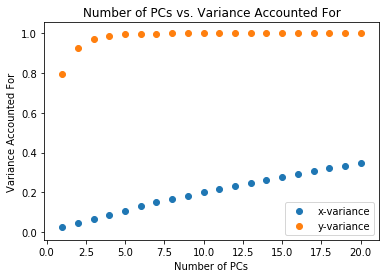

In [6]:
import scipy as sp, numpy as np
import scipy.io as sio
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import scipy
from scipy import stats

# calculation of R2X and R2Y to discover how many primary components to use

x_zscore = scipy.stats.mstats.zscore(X, axis=0)
Y_mean = np.mean(Y)
Y_std = np.std(Y)
y_zscore = scipy.stats.zscore(Y)

X_R2_data = []
Y_R2_data = []

def make_params_R2 (scores, loadings, observed):
    loadings_transpose = np.ndarray.transpose(loadings)
    x_model = np.squeeze(np.dot(scores, loadings_transpose))
    # when is squeeze necessary
    return (R2(x_model, observed))

def R2 (x_model, observed):
    sum_sq_err = np.sum(np.square(np.squeeze(np.subtract(x_model, observed))))
    sq_obs = np.sum(np.square(observed))
    return 1 - (sum_sq_err/sq_obs)

max_pcs = 20
reach_90_x = False
reach_90_y = False

for i in range(max_pcs):
    pls= PLSRegression(n_components=(i+1))
    pls.fit(x_zscore,y_zscore)
    new_R2_X = make_params_R2(pls.x_scores_, pls.x_loadings_, x_zscore)
    X_R2_data.append(new_R2_X)
    if (new_R2_X > 0.9) and not reach_90_x:
        print((100*new_R2_X), "% of variation for x accounted for using",(i+1), "PCs.")
        reach_90_x = True
    
    Y_model = np.squeeze(pls.predict(x_zscore))
    new_R2_Y = R2(Y_model, y_zscore)
    Y_R2_data.append(new_R2_Y)
    if (new_R2_Y > 0.9) and not reach_90_y:
        print((100*new_R2_Y), "% of variation for y accounted for using", (i+1), "PCs.")
        reach_90_y = True

#plt.figure(figsize =(1300,80), dpi=100)
plt.title("Number of PCs vs. Variance Accounted For")
plt.scatter(np.arange(1,max_pcs+1), X_R2_data, label="x-variance")
plt.scatter(np.arange(1,max_pcs+1), Y_R2_data, label="y-variance")
plt.xlabel("Number of PCs")
plt.ylabel("Variance Accounted For")
plt.legend()
plt.show()

In [25]:
# Leave one out cross validation on our on our PLSDA model

num_of_comp = 2
loo = LeaveOneOut()


Y_raw_loo = []
Y_test_loo = []
pls_loo = PLSRegression(n_components=(num_of_comp))

for train_index, test_index in loo.split(X, Y):
    
    pls_loo.fit_transform(X[train_index], Y[train_index])
    pls_loo.transform(X[test_index])
    new_y_pred = pls_loo.predict(X[test_index])
    Y_raw_loo.append(np.squeeze(new_y_pred))
    Y_test_loo.append((Y[test_index]))


In [33]:
Y_predict_loo = []
for i in range(100):
    if Y_raw_loo[i] >= 0.45:
        Y_predict_loo.append(np.squeeze(1))
    else:
        Y_predict_loo.append(np.squeeze(0))
    
np.squeeze(Y_predict_loo)
np.squeeze(Y_test_loo)
mes_correct = 0
pro_correct = 0
for i in range(100):
    if (Y_predict_loo[i] == Y_test_loo[i]):
        if Y_predict_loo[i] == 0:
            mes_correct += 1
        else:
            pro_correct += 1

print("mes cells correctly predicted: ", mes_correct)
print("pro cells correctly predicted: ", pro_correct)

mes cells correctly predicted:  44
pro cells correctly predicted:  43


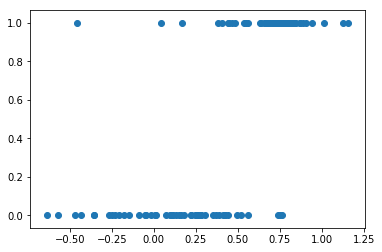

0.40433849569477104


In [21]:
plt.scatter(Y_raw_loo, Y_test_loo)
plt.show()
print(np.mean(Y_raw_loo))